# Predicting Goals using Poisson 
reference: [oddsdigger.com](https://oddsdigger.com/za/blog/poisson-distribution-explained)

Using data from 1872-11-30 to 2018-06-09

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


In [5]:
matches = pd.read_csv("int_results1872-2018.csv")

In [6]:
matches = matches.astype({'date':'datetime64[ns]'})

In [5]:
# all matches from 1994 onwards
matches94 = matches[matches.date.dt.year>1993]

In [14]:
matches.tournament.value_counts()

Friendly                                16476
FIFA World Cup qualification             7100
UEFA Euro qualification                  2332
African Cup of Nations qualification     1558
FIFA World Cup                            836
Copa América                              787
AFC Asian Cup qualification               724
African Cup of Nations                    638
CECAFA Cup                                620
CFU Caribbean Cup qualification           606
Merdeka Tournament                        504
British Championship                      501
Gulf Cup                                  333
AFC Asian Cup                             319
Gold Cup                                  296
UEFA Euro                                 286
Nordic Championship                       283
COSAFA Cup                                272
AFF Championship                          267
CFU Caribbean Cup                         251
Amílcar Cabral Cup                        235
King's Cup                        

In [6]:
matches94.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
39040,2018-06-09,Estonia,Morocco,1,3,Friendly,Tallinn,Estonia,False
39041,2018-06-09,Latvia,Azerbaijan,1,3,Friendly,Riga,Latvia,False
39042,2018-06-09,Finland,Belarus,2,0,Friendly,Tampere,Finland,False
39043,2018-06-09,Tunisia,Spain,1,0,Friendly,Krasnodar,Russia,True
39044,2018-06-09,France,USA,1,1,Friendly,Lyon,France,False


---
Basic Function to predict Goals using Home and Away stats.

Home being the favourite to win

In [9]:
def pred_goals(home, away, friendlies=True, min_year=1994):
    matches_recent = matches[matches.date.dt.year > (min_year-1)]
    goal_expectancy = {}
    home_team = {}
    away_team = {}
    
    if friendlies:
        home = matches_recent[matches_recent['home_team'] == home][['home_team', 'home_score', 'away_score']] 
        away = matches_recent[matches_recent['away_team'] == away][['away_team', 'home_score', 'away_score']]
    else:
        home  = matches_recent[(matches_recent['home_team'] == home) & (matches_recent['tournament'] != 'Friendly')][['home_team', 'home_score', 'away_score']]
        away  = matches_recent[(matches_recent['away_team'] == away) & (matches_recent['tournament'] != 'Friendly')][['away_team', 'home_score', 'away_score']]
        
    home_name = home.home_team.min()
    away_name = away.away_team.min()
    
    # home team stats
    home_team['ave_goals_for']     = home.home_score.mean()
    home_team['ave_goals_against'] = home.away_score.mean()
    home_team['attack_strength']   = home_team['ave_goals_for']     / matches_recent.home_score.mean()
    home_team['defense_strength']  = home_team['ave_goals_against'] / matches_recent.away_score.mean()
    
    # away team stats
    away_team['ave_goals_for']     = away.away_score.mean()
    away_team['ave_goals_against'] = away.home_score.mean()
    away_team['attack_strength']   = away_team['ave_goals_for']     / matches_recent.away_score.mean()
    away_team['defense_strength']  = away_team['ave_goals_against'] / matches_recent.home_score.mean()
    
    # Home Team goal expectancy
    # home team attacking strength X away team defensive strength X average goals home team
    goal_expectancy['home_team_goals'] = home_team['attack_strength'] * away_team['defense_strength'] * matches_recent.home_score.mean()
    
    # Away Team goal expectancy
    # away team attacking strength X home team defensive strength X ave goals away team
    goal_expectancy['away_team_goals'] = away_team['attack_strength'] * home_team['defense_strength'] * matches_recent.away_score.mean()


    # construct Poisson  for each mean goals value
    poisson_pred_t1 = [poisson.pmf(k,home_team['ave_goals_for']) for k in range(10)]
    poisson_pred_t2 = [poisson.pmf(k,away_team['ave_goals_for']) for k in range(10)]

    plt.figure(figsize=(15,10))
    # plot histogram of actual goals
    plt.hist([home['home_score'].values, away['away_score'].values], range(11), alpha=0.7,
             label=[home_name, away_name], normed=True, color=["#3498db", "#e74c3c"])

    # add lines for the Poisson distributions
    pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t1,
                  linestyle='-', marker='o',label=home_name, color = '#2980b9')
    pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t2,
                  linestyle='-', marker='o',label=away_name, color = '#c0392b')

    leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
    leg.set_title("Poisson          Actual      ", prop = {'size':'18', 'weight':'bold'})

    plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
    plt.xlabel("Goals per Match",size=18)
    plt.ylabel("Proportion of Matches",size=18)
    plt.title("Number of Goals per Match",size=20,fontweight='bold')
    plt.show()
        
    print(f"{home_name} is predicted to score {goal_expectancy['home_team_goals']:.3}")
    print(f"{away_name} is predicted to score {goal_expectancy['away_team_goals']:.3}")
    
    print(f"\nUsing the results of {len(matches_recent)} matches. since {min_year},\
          \n{home_name} played {len(home)} games at home and {away_name} played {len(away)} games away")
    
    home_max_prob = max(poisson_pred_t1)
    away_max_prob = max(poisson_pred_t2)
    print(f"\n{home_name} will most likely score {poisson_pred_t1.index(home_max_prob)} with a probability of {home_max_prob}")
    print(f"{away_name} will most likely score {poisson_pred_t2.index(away_max_prob)} with a probability of {away_max_prob}")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


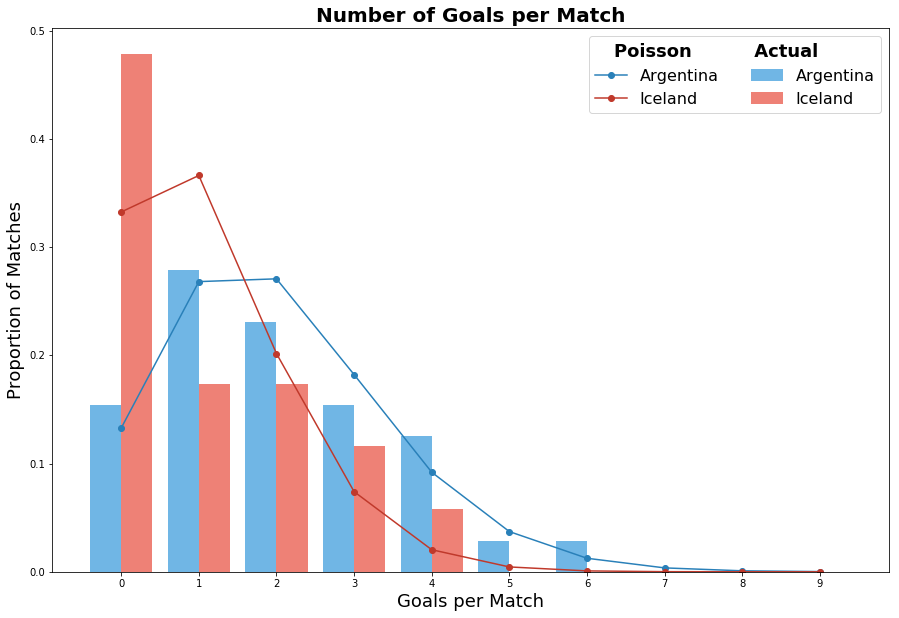

Argentina is predicted to score 2.13
Iceland is predicted to score 0.715

Using the results of 21076 matches. since 1994,          
Argentina played 104 games at home and Iceland played 69 games away

Argentina will most likely score 2 with a probability of 0.27064570186871406
Iceland will most likely score 1 with a probability of 0.3661096355795859


In [19]:
pred_goals("Argentina", "Iceland", friendlies=False)